# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
N = 50
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

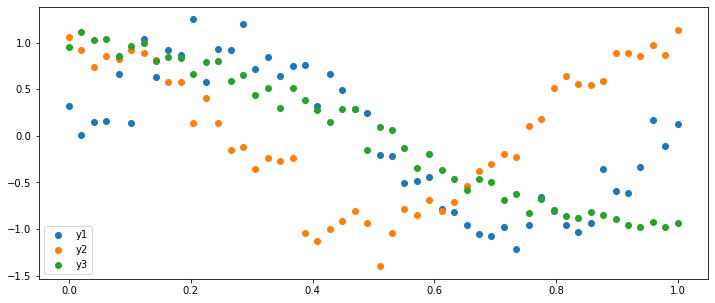

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [9]:
M = 80
xnew = np.linspace(-0.5, 1.5, M)
Xnew = pm.math.cartesian(xnew, task_i) # For prediction
Xnew.shape

(240, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [10]:
Xs[0].shape, Xs[1]

((50, 1),
 array([[0.],
        [1.],
        [2.]]))

In [11]:
# y = (K + noise) * α = (L x L.T) * α = y
# B = L * α
# L.T * B = y
# B = solve(y, L) = (L\y)
# α = solve(B, L.T) = (B\L.T) = L\(L\y)

In [12]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [13]:
coreg.full(task_i).eval()

array([[51.88589386, 20.15064538,  5.28574483],
       [20.15064538, 12.30182875,  5.6185138 ],
       [ 5.28574483,  5.6185138 , 10.71053638]])

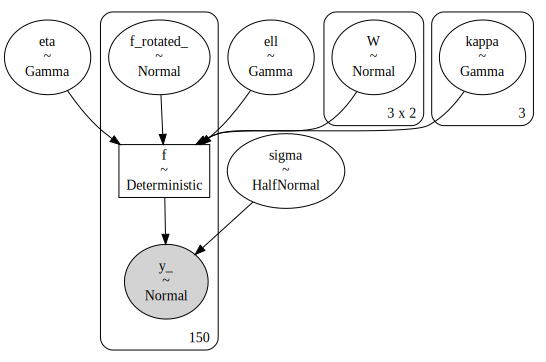

In [14]:
pm.model_to_graphviz(model)

In [15]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 287 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 11min 22s, sys: 25min 23s, total: 36min 45s
Wall time: 4min 52s


#### Prediction

In [16]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 25.8 s, sys: 33.3 s, total: 59.1 s
Wall time: 9.73 s


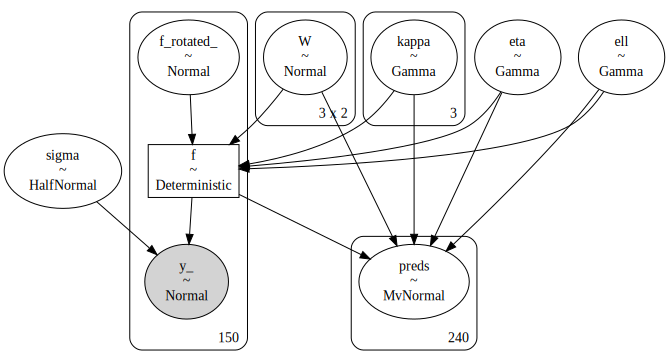

In [17]:
pm.model_to_graphviz(model)

In [18]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the first GP

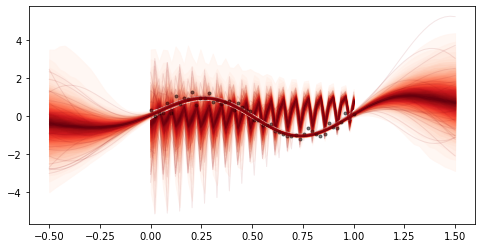

In [19]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], xnew)
plt.show()

#### Plot the second GP

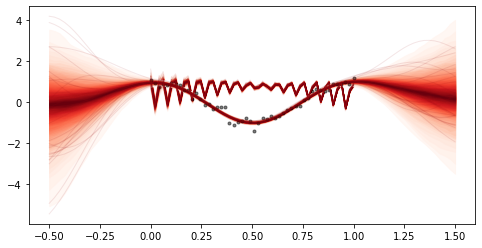

In [20]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, N:2*N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], xnew)
plt.show()

### Option 1.2: Implement ICM (one kernel) by using MarginalKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [21]:
Xs[0].shape, Xs[1]

((50, 1),
 array([[0.],
        [1.],
        [2.]]))

In [22]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    mogp = pm.gp.MarginalKron(cov_funcs=[cov, coreg])    
            
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    y_ = mogp.marginal_likelihood("y", Xs=Xs, y=y.squeeze(), sigma=sigma)

In [23]:
coreg.full(task_i).eval()

array([[ 8.30487053, -5.67468675, -7.03474024],
       [-5.67468675, 14.62197889, 11.83734117],
       [-7.03474024, 11.83734117, 12.31682443]])

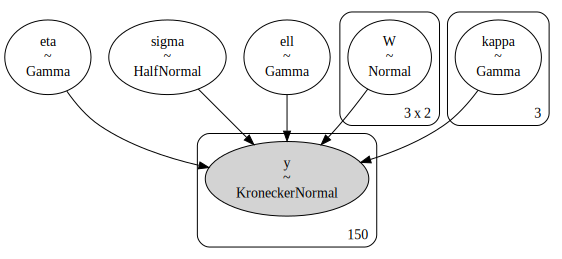

In [24]:
pm.model_to_graphviz(model)

In [25]:
# THIS TAKES LONG TIME TO SAMPLE !!!!!
# %%time
# with model:
#     gp_trace = pm.sample(500, chains=1)

### Option 2.1: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [26]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [27]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [28]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [29]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 95 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 4min 26s, sys: 8min 6s, total: 12min 32s
Wall time: 1min 41s


#### Prediction

In [30]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 22.7 s, sys: 25.1 s, total: 47.8 s
Wall time: 7.01 s


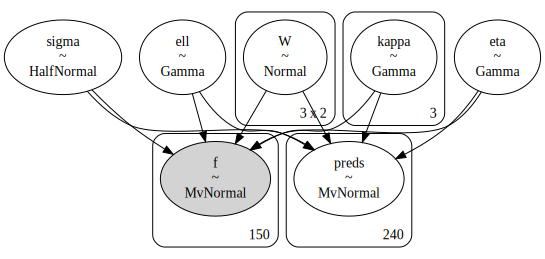

In [31]:
pm.model_to_graphviz(model)

In [32]:
Xnew.shape

(240, 2)

In [33]:
Marginalf_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the GP prediction

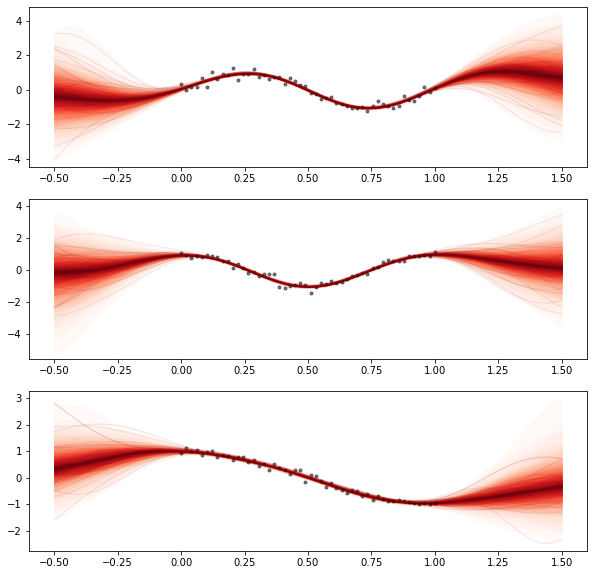

In [34]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [35]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.040,2.190,-4.016,4.628,0.123,0.097,315.0,373.0,NaN
"W[0, 1]",-0.079,2.097,-4.076,3.429,0.111,0.098,353.0,341.0,NaN
"W[1, 0]",0.092,2.143,-3.713,3.946,0.116,0.191,335.0,206.0,NaN
"W[1, 1]",0.074,2.194,-4.231,3.826,0.119,0.110,334.0,315.0,NaN
"W[2, 0]",0.064,1.085,-1.966,2.181,0.055,0.062,446.0,214.0,NaN
"W[2, 1]",0.003,1.145,-1.941,2.381,0.062,0.059,355.0,308.0,NaN
ell,0.336,0.043,0.253,0.410,0.003,0.002,286.0,308.0,NaN
eta,0.695,0.263,0.299,1.214,0.018,0.013,194.0,315.0,NaN
kappa[0],1.928,1.307,0.199,4.251,0.069,0.049,320.0,287.0,NaN
kappa[1],1.823,1.519,0.014,4.525,0.062,0.045,358.0,196.0,NaN


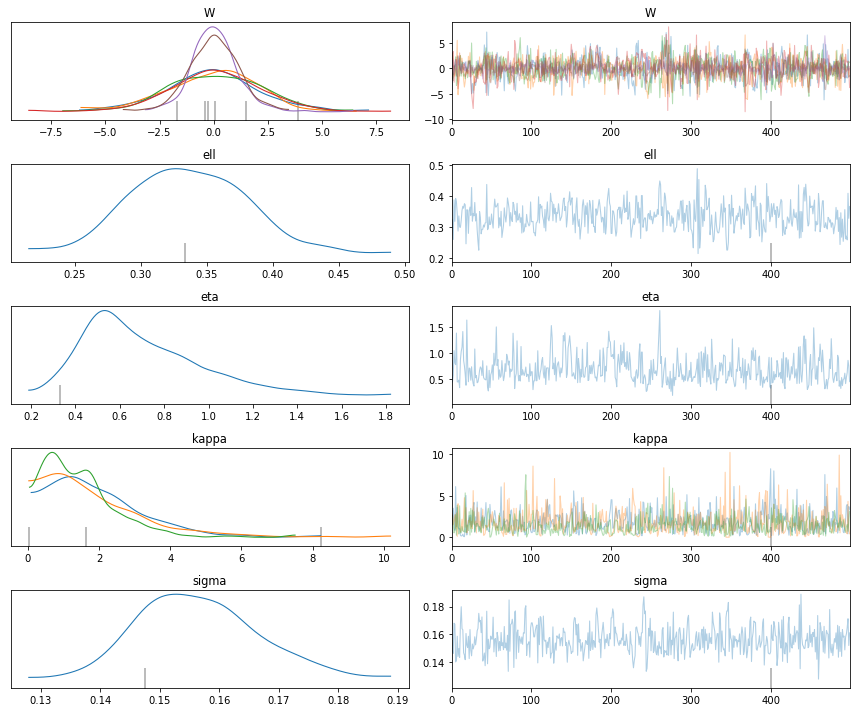

In [36]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Option 2.2: Implement LCM by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) \otimes K_2(o, o')
$$

In [37]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [38]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=3, beta=1)
    cov2 = eta2**2 * pm.gp.cov.Matern32(1, ls=ell2)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov+cov2, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [39]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [40]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 157 seconds.
The acceptance probability does not match the target. It is 0.8961, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 7min 21s, sys: 13min 28s, total: 20min 50s
Wall time: 2min 49s


#### Prediction

In [41]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 29.9 s, sys: 36.5 s, total: 1min 6s
Wall time: 9.92 s


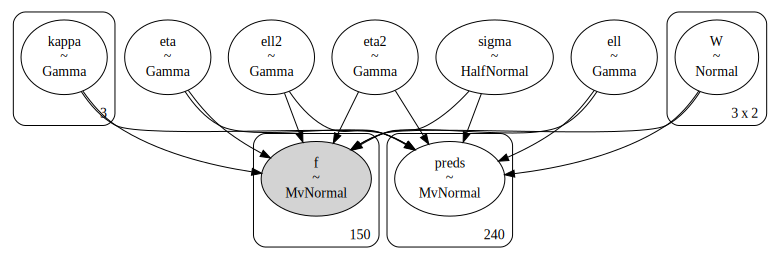

In [42]:
pm.model_to_graphviz(model)

In [43]:
Xnew.shape

(240, 2)

In [44]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 240)

#### Plot the GP prediction

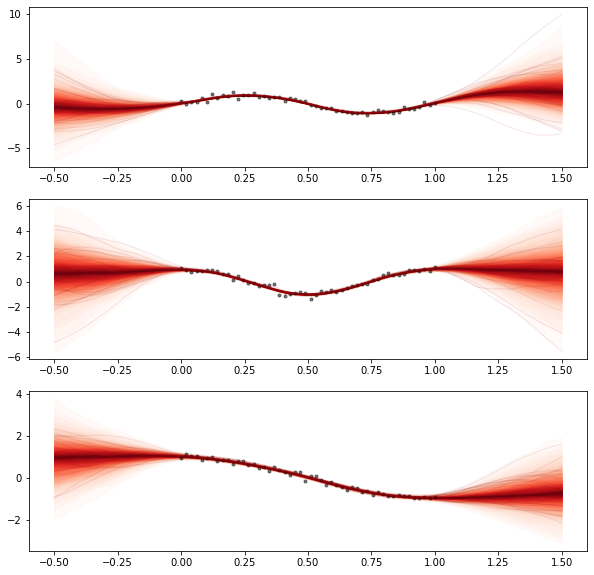

In [45]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [46]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.099,2.413,-4.862,4.049,0.157,0.145,237.0,247.0,NaN
"W[0, 1]",0.022,2.361,-5.566,3.560,0.163,0.115,210.0,236.0,NaN
"W[1, 0]",-0.074,2.225,-3.984,4.484,0.128,0.091,295.0,472.0,NaN
"W[1, 1]",0.146,2.183,-4.151,3.787,0.129,0.091,288.0,358.0,NaN
"W[2, 0]",-0.042,0.998,-1.800,1.873,0.052,0.053,403.0,236.0,NaN
"W[2, 1]",-0.004,0.842,-1.763,1.396,0.041,0.043,378.0,299.0,NaN
ell,2.053,2.991,0.218,7.910,0.968,0.707,9.0,108.0,NaN
eta,1.175,0.852,0.262,2.591,0.080,0.057,125.0,142.0,NaN
ell2,3.454,2.473,0.675,7.933,0.543,0.389,15.0,272.0,NaN
eta2,1.289,0.927,0.130,3.063,0.158,0.113,33.0,243.0,NaN


In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 16 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pymc      : 4.1.7
arviz     : 0.12.1
numpy     : 1.22.4
matplotlib: 3.5.2

Watermark: 2.3.0

